###### init

In [1]:
# import
from elec_bol20 import *
import elec_bol20.util as ebu
import bokeh.layouts
from bokeh.models import ColumnDataSource, CustomJS, Slider
from bokeh.plotting import Figure
# output_file, show
import bokeh.tile_providers

In [2]:
# p = os.path.pardir(ebu.DIR)

In [13]:
W_CARTO = 400
H_CARTO = 400
ANGLE_DENS = .35
SIZE_DENS = "8pt"
HEIGHT_BDENS = 200
H_FIG_PARTY = 200
WW = W_CARTO
BROWSER = 'safari'
MIN_WITH = 500
MAX_WITH = 600
PATH_OUT = 'docs/Ejemplos/z051_panel.html'
FILE_OUT = os.path.join(os.path.dirname(ebu.DIR),
                        PATH_OUT)

COL_LLEGO = '#aaaaaa'
COL_FALTA = '#db2879'

In [14]:
## MAIN
bokeh.plotting.output_notebook()


# bokeh.plotting.output_file(os.path.join(os.path.dirname(ebu.DIR),
#                                         PATH_OUT))
# bokeh.plotting.output_notebook()

### FUNS

def main(df2):
    cols = ['yj', 'xj', 'PAIS', 'MUN', 'REC', 'HAB', 'COU']

    df2 = process_data(df2)
    den1 = get_den1(df2)
    ppp = den1['counted'].sum() / den1['HAB'].sum() * 100

    s1 = df2[df2['COUNT']][cols]
    s2 = df2[~df2['COUNT']][cols]
    sr1 = bokeh.models.ColumnDataSource(s1)
    sr2 = bokeh.models.ColumnDataSource(s2)

    fig_carto = plot_fig_carto(sr1, sr2)
    fig_bar_dens = plot_fig_bar_dens(den1, ppp)
    fig_party = plot_fig_party(df2, ppp)

    l0 = bokeh.layouts.column([fig_party, fig_bar_dens, fig_carto],
                              sizing_mode='scale_width')

    lay = l0
    l0.max_width = MAX_WITH
    l0.min_width = MIN_WITH

    bokeh.plotting.show(lay, browser=BROWSER)
    bokeh.plotting.save(l0, FILE_OUT)

    ebu.get_bolivian_time(0)


def plot_fig_party(df2, ppp):
    _c = ['CREEMOS', 'MAS', 'FPV', 'PAN_BOL', 'CC']
    dd = df2[[*_c, 'VV']].copy()
    res = dd[_c].sum() / dd['VV'].sum() * 100
    res.name = 'per'
    res.index.name = 'party'
    res = res.reset_index()
    res['i'] = res.index + .5
    se = pd.Series(ebu.C_DIC)
    se.name = 'colors'
    res = pd.merge(res, se, left_on='party', right_index=True)
    source = ColumnDataSource(res)
    fig_party = bokeh.plotting.figure(x_range=res['party'],
                                      toolbar_location=None,
                                      height=H_FIG_PARTY, width=WW)
    fig_party.vbar(x='i', top='per', width=0.9, source=source,
                   line_color='white',
                   fill_color=bokeh.transform.factor_cmap('party',
                                                          palette=res['colors'],
                                                          factors=res['party']))

    def _f(p):
        return f'{p:0.1f}%'

    res['t'] = res['per'].apply(_f)
    fig_party.text(x=res['i'], y=res['per'], text=res['t'], text_align='center')
    fig_party.xgrid.grid_line_color = None
    fig_party.y_range.start = 0
    fig_party.y_range.end = np.ceil(res['per'].max() / 20) * 20
    fig_party.title.text = \
        f'Porcentaje sobre el total de ' \
        f'votos válidos computados ({ppp:0.1f}%)'
    fig_party.y_range.end = 70
    return fig_party


def plot_fig_bar_dens(den1, ppp):
    fig_bar_dens = bokeh.plotting.figure(height=HEIGHT_BDENS, width=WW)
    # fi = bokeh.plotting.figure()
    fig_bar_dens.vbar(x=den1['mid'], width=den1['width'], top=den1['top'],
                      color=COL_FALTA)
    fig_bar_dens.vbar(x=den1['mid'], width=den1['width'], top=den1['top_c'],
                      color=COL_LLEGO)
    fig_bar_dens.title.text = ''
    x = den1[den1.index >= 0]['mid'].mean()
    fig_bar_dens.text(x=[x], y=[140], text=['Nacional'])
    an = ANGLE_DENS
    x = den1[den1.index == 0]['mid'].mean()
    fig_bar_dens.text(x=[x], y=[101], text=['Densidad baja (0-50)'], angle=an,
                      text_font_size=SIZE_DENS)
    x = den1[den1.index == 1]['mid'].mean()
    fig_bar_dens.text(x=[x], y=[101], text=['Densidad media (50-500)'],
                      angle=an,
                      text_font_size=SIZE_DENS)
    x = den1[den1.index == 2]['mid'].mean()
    fig_bar_dens.text(x=[x], y=[101], text=['Densidad moderada (500-1500)'],
                      angle=an, text_font_size=SIZE_DENS)
    x = den1[den1.index == 3]['mid'].mean()
    fig_bar_dens.text(x=[x], y=[101], text=['Densidad alta > 1500'], angle=an,
                      text_font_size=SIZE_DENS)
    x = den1[den1.index < 0]['mid'].mean()
    fig_bar_dens.text(x=[x], y=[110], text=['Exterior'], text_align='center')
    fig_bar_dens.xaxis.visible = False
    fig_bar_dens.xgrid.visible = False
    fig_bar_dens.ygrid.visible = False
    fig_bar_dens.y_range.start = 0
    fig_bar_dens.y_range.end = 160
    fig_bar_dens.yaxis.axis_label = "Porcentaje"
    fig_bar_dens.title.text = f'Porcentaje de votos computados por densidad (total computado={ppp:0.1f}%)'
    fig_bar_dens.xaxis.axis_label = f'Porcentaje total de votos computados = ({ppp:0.1f}%)'
    fig_bar_dens.toolbar.logo = None
    fig_bar_dens.toolbar_location = None
    for l, fig_party in den1.iterrows():
        if l == -1:
            x = fig_party['mid'] + 400000
        else:
            x = fig_party['mid']

        fig_bar_dens.text(x=x, y=[fig_party['tc']], text=[fig_party['text']],
                          text_align='center', text_font_size="8pt",
                          color=[COL_LLEGO])
    return fig_bar_dens


def get_den1(df2):
    dfn = df2.copy()
    dfn.loc[~dfn['BOL'], 'DEN_CODES'] = -1
    # %%
    _df = dfn
    gr = _df.groupby('DEN_CODES')
    den = gr[['HAB']].sum()
    den['cum'] = den['HAB'].cumsum()
    tot = den['HAB'].sum()
    den['mid'] = den['cum'] - den['HAB'] / 2
    den['top'] = 100
    den['width'] = den['HAB'] - (tot * .01)
    den1 = den.copy()
    # %%
    _df = dfn[dfn['COUNT']]
    gr = _df.groupby('DEN_CODES')
    den = gr[['HAB']].sum()
    den['cum'] = den['HAB'].cumsum()
    tot = den['HAB'].sum()
    den['mid'] = den['cum'] - den['HAB'] / 2
    den['top'] = 1
    den['width'] = den['HAB'] - (tot * .01)
    den2 = den.copy()
    # %%
    # %%
    den1['counted'] = den2['HAB'].astype(np.int64)
    # %%
    den1['top_c'] = den1['counted'] / den1['HAB'] * 100

    # %%

    def _t(s):
        if np.isnan(s): s = 0
        return f'{s:0.1f}'

    def _t1(s):
        if np.isnan(s): s = 0
        return f'{s:0.0f}'

    def _t2(r):
        #     return f'{r["tv"]} ({r["tc"]} %)'
        return f'{r["tc"]}%'

    den1.loc[-1, 'mid'] = den1.loc[-1, 'mid'] - 1000000
    den1['tc'] = den1['top_c'].apply(_t)
    den1['tv'] = den1['counted'].apply(_t1)
    den1['text'] = den1.apply(_t2, axis=1)

    return den1


def plot_fig_carto(sr1, sr2):
    fig_carto = bokeh.plotting.figure(output_backend="webgl", height=H_CARTO,
                                      width=W_CARTO)
    fig_carto.scatter(x='xj', y='yj', source=sr2, color=COL_FALTA, radius=.05,
                      alpha=1,
                      legend_label='Mesas por computar (haz click)')
    fig_carto.scatter(x='xj', y='yj', source=sr1, color=COL_LLEGO, radius=.05,
                      alpha=1,
                      legend_label='Mesas computadas (haz click)')
    fig_carto.legend.click_policy = "hide"

    fig_carto.yaxis.visible = False
    fig_carto.yaxis.visible = False

    fig_carto.title.text = "Cartolocación de las mesas"

    TOOL_TIP = [
        ('Inscritos', '@HAB'),
        ('PAIS, Municipalidad', '@PAIS, @MUN'),
        ('Recinto', '@REC'),
        ('Computada', '@COU'),
        # ('MAS [%]', '@mas{0.0}'),
        # ('CC [%]','@cc{0.0}'),
        # ('Diferencia [%]', '@ad_mas_cc{0.0} (@mas_o_cc)'),
        ('------', '------')
        # ('DEN %', '@DEN')
        # ('PAIS', '@PAIS'),
    ]

    hover_map = bokeh.models.HoverTool(
        tooltips=TOOL_TIP,
        # callback=callback_red_car,
        # renderers = [red_scat_map]
    )

    fig_carto.add_tools(hover_map)

    return fig_carto


def process_data(df2):
    ll = len(df2)
    np.random.seed(100)
    df2['xj'] = df2['X'] + np.random.rand(ll) * .5
    np.random.seed(200)
    df2['yj'] = df2['Y'] + np.random.rand(ll) * .5

    df2['COU'] = 'No'
    df2.loc[df2['COUNT'], 'COU'] = 'Sí'
    return df2


df2 = ebu.get_dataframe_2020(
    path=ebu.FULL_COMP_CONCAT_CSV,
    col2keep=['VV', 'BL', 'NU', 'VOTO_EMITIDO', 'CREEMOS', 'MAS', 'FPV',
              'PAN_BOL', 'CC', 'NUA', 'HAB', 'TIMESTAMP', 'P_COMP']
)

main(df2)

Loading BokehJS ...

/Users/diego/miniconda3/envs/ebol20/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/Users/diego/miniconda3/envs/ebol20/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


In [15]:
_df['P_COMP']

NameError: name '_df' is not defined

In [16]:
df2.columns

Index(['VV', 'BL', 'NU', 'VOTO_EMITIDO', 'CREEMOS', 'MAS', 'FPV', 'PAN_BOL',
       'CC', 'NUA', 'HAB', 'TIMESTAMP', 'P_COMP', 'ID_RECI', 'COUNT', 'INHAB',
       '.before', 'LAT', 'LON', 'PAIS', 'N_MESAS', 'REC', 'MUN', 'BOL', 'CIU',
       'PROV', 'DEP', 'URB', 'DEN_C', 'DEN', 'X', 'Y', 'DEN_CODES', 'xj', 'yj',
       'COU'],
      dtype='object')

In [17]:
IS = 5
_df = df2[['xj', 'yj','P_COMP']].copy()
_df = _df.dropna(how='any')
RR = .1
_df['pr'] = RR
_df['r'] = RR

_df.loc[_df['P_COMP']>IS,'pr'] = 0
_df = _df.sort_values('P_COMP')

TT = [
    ('pr','@pr')
]

ht = bokeh.models.HoverTool(
    tooltips = TT
)

ss = bokeh.plotting.ColumnDataSource(_df[['xj', 'yj','P_COMP','pr','r']])

slider = bokeh.models.Slider(
    start=0, end=100, value=10, step=IS, 
                             title='Porcentaje computado')
cb = bokeh.models.CustomJS(
    args=dict(ss=ss, slider=slider),
    code="""
    const data=ss.data;
    const v=slider.value
    const P_COMP = data['P_COMP']
    const pr = data['pr']
    const r = data['r']
    for (var i = 0;i < P_COMP.length; i++){
 
        if (P_COMP[i]<v) {
            pr[i] = r[i]
            
        } else {
            pr[i] = 0
        }
    }
    
    ss.change.emit()
    
    """
)

slider.js_on_change('value', cb)
bokeh.plotting.reset_output()
bokeh.plotting.output_notebook()
f = bokeh.plotting.figure(output_backend="webgl")
f.circle(x='xj', y='yj', source=ss, radius='pr', line_width=0, alpha=.5 )
f.add_tools(ht)
ly = bokeh.plotting.Column(f, slider)
bokeh.plotting.show(ly)

Loading BokehJS ...

In [18]:
df3 = df2.copy()
df3['mun_id'] = np.floor(df3.index/1e9).astype(np.int64)
gr = df3.groupby('mun_id')
ll = []
for l,t in gr:
    tt = t[['MUN']].copy()
    boo =tt['MUN'].drop_duplicates()
    n = len(boo)
    l_ = pd.DataFrame([[0,n]],columns=['MUN','N'])

    
    ll.append(l_)
nd = pd.concat(ll)
nd.describe()

MUN           N
count  263.0  263.000000
mean     0.0    5.228137
std      0.0    5.261959
min      0.0    1.000000
25%      0.0    1.000000
50%      0.0    3.000000
75%      0.0    8.000000
max      0.0   27.000000

In [39]:
cols =['PAIS','DEP','PROV','MUN']
gdf.columns

Index(['VV', 'BL', 'NU', 'VOTO_EMITIDO', 'CREEMOS', 'MAS', 'FPV', 'PAN_BOL',
       'CC', 'NUA', 'HAB', 'TIMESTAMP', 'P_COMP', 'ID_RECI', 'COUNT', 'INHAB',
       '.before', 'LAT', 'LON', 'PAIS', 'N_MESAS', 'REC', 'MUN', 'BOL', 'CIU',
       'PROV', 'DEP', 'URB', 'DEN_C', 'DEN', 'X', 'Y', 'DEN_CODES', 'xj', 'yj',
       'COU', 'geometry'],
      dtype='object')

In [21]:
gdf = gdf.set_geometry(pdt)

In [22]:
gdf.columns

Index(['VV', 'BL', 'NU', 'VOTO_EMITIDO', 'CREEMOS', 'MAS', 'FPV', 'PAN_BOL',
       'CC', 'NUA', 'HAB', 'TIMESTAMP', 'P_COMP', 'ID_RECI', 'COUNT', 'INHAB',
       '.before', 'LAT', 'LON', 'PAIS', 'N_MESAS', 'REC', 'MUN', 'BOL', 'CIU',
       'PROV', 'DEP', 'URB', 'DEN_C', 'DEN', 'X', 'Y', 'DEN_CODES', 'xj', 'yj',
       'COU', 'geometry'],
      dtype='object')

In [43]:
colors = sns.color_palette('Set1',len(dis))

In [119]:
df2.columns

Index(['VV', 'BL', 'NU', 'VOTO_EMITIDO', 'CREEMOS', 'MAS', 'FPV', 'PAN_BOL',
       'CC', 'NUA', 'HAB', 'TIMESTAMP', 'P_COMP', 'ID_RECI', 'COUNT', 'INHAB',
       '.before', 'LAT', 'LON', 'PAIS', 'N_MESAS', 'REC', 'MUN', 'BOL', 'CIU',
       'PROV', 'DEP', 'URB', 'DEN_C', 'DEN', 'X', 'Y', 'DEN_CODES', 'xj', 'yj',
       'COU'],
      dtype='object')

In [273]:
import geopandas as gp
import shapely as sh
gdf = gp.GeoDataFrame(df2)
# pdt = gdf.apply(lambda r: sh.geometry.Point(r['LON'],r['LAT']),axis=1)
pdt = gdf.apply(lambda r: sh.geometry.Point(r['X'],r['Y']),axis=1)
gdf = gdf.set_geometry(pdt)
dis = gdf.dissolve(by=cols)
dis['DEN_CODES'] = gdf.groupby(cols)['DEN_CODES'].median()
dis['HAB'] = gdf.groupby(cols)['HAB'].sum()

dis = dis.iloc[::1]
dis = dis.set_geometry(dis['geometry'].buffer(.2).simplify(.1))


In [274]:
gs = dis.reset_index()[['geometry','MUN','HAB','DEN_CODES']].to_json()

In [275]:
sr = bokeh.models.GeoJSONDataSource(geojson=gs)
cm = bokeh.transform.linear_cmap('DEN_CODES',palette=bokeh.palettes.Viridis6,low=0,high=3)
f.add_tools(ht)
f = bokeh.plotting.figure()
ht=bokeh.models.HoverTool(tooltips=[('MUN','@MUN'),('DC','@DEN_CODES'),('HAB','@HAB'),('--','--')])
states = f.patches('xs','ys', source = sr,
                   fill_color = cm,
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = .5,
                  hover_fill_color="firebrick"
                  )
f.add_tools(ht)
bokeh.plotting.output_file('/tmp/go_to_sleep.html')
bokeh.plotting.show(f)



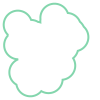

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [345]:
pp = gp.read_file('/Volumes/mbProD/Downloads/Municipios339.shp')
pp = pp.sample(ll)
pp = pp.reset_index(drop=True)
pp = pp.set_geometry(pp.simplify(.02))
# pp

In [344]:
pp

gid     NOM_DEP          nombre_com      id_unico tipo_area  poblacion  \
0       53  SANTA CRUZ           LACAYOTAL  4507828313-D       dis      132.0   
1    17387      TARIJA          LAS SIDRAS  2914885263-D       dis      224.0   
2     5473        BENI  COLONIA SAN JUAN\n  7255311978-D      None        0.0   
3    10707      LA PAZ             HUACUYO  5705429118-D       dis       54.0   
4    22910  COCHABAMBA         SAN JOAQUIN  5620354616-D      None        0.0   
..     ...         ...                 ...           ...       ...        ...   
339  13997      POTOSI    SAN ANTONIO BAJO  3496390014-D       dis       62.0   
340  23645  COCHABAMBA   SANTA ROSA IBUELO  5430706944-D       dis       39.0   
341  12300      POTOSI          ÑUÑUMAYANI  4448115927-D       dis       16.0   
342   3437  SANTA CRUZ            PROGRESO  6082749763-D       dis        4.0   
343   7216      LA PAZ          CHARANTAZI  7163779931-D       dis       49.0   

     viviendas                     geometry  
0         41.0  POINT (-64.09435 -18.76765)  
1         62.0  POINT (-63.99107 -22.09695)  
2          0.0  POINT (-66.98880 -15.10033)  
3         12.0  POINT (-68.96300 -17.07587)  
4          0.0  POINT (-65.04855 -16.95089)  
..         ...                          ...  
339       25.0  POINT (-65.40464 -20.17189)  
340       22.0  POINT (-65.24745 -17.19398)  
341        8.0  POINT (-66.14179 -18.47634)  
342        4.0  POINT (-62.99718 -16.51500)  
343       19.0  POINT (-68.20048 -15.42980)  

[344 rows x 8 columns]

In [319]:
ll = len(pp)

cc = [*bokeh.palettes.magma(256),*bokeh.palettes.viridis(ll-256)]

In [339]:
pp['POBLACION']=pp['POBLACION'].astype(np.double)
pp = pp[pp['POBLACION']>=0]
ma = pp['POBLACION'].max()

In [340]:
ma

715900.0

In [341]:
sr = bokeh.models.GeoJSONDataSource(geojson=pp.reset_index()[['index','geometry','NOM_MUN','POBLACION']].to_json())
cm = bokeh.transform.linear_cmap('POBLACION',palette=bokeh.palettes.Viridis256,low=0,high=ma)
f.add_tools(ht)
f = bokeh.plotting.figure()
ht=bokeh.models.HoverTool(tooltips=[('MUN','@NOM_MUN'),('DC','@DEN_CODES'),('HAB','@POBLACION'),('--','--')])
states = f.patches('xs','ys', source = sr,
                   fill_color = cm,
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1,
                  hover_fill_color="firebrick"
                  )
f.add_tools(ht)
bokeh.plotting.output_file('/tmp/go_to_sleep.html')
bokeh.plotting.show(f)